In [2]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
from sklearn.model_selection import train_test_split

from models import RealNVP
from models import AutoEncoderA, AutoEncoderC, AutoEncoderA2, AutoencoderA3, AutoEncoderB

device = torch.device("cuda")

data_dir = "data/"
figs_dir = os.path.join(os.getcwd(), "figs/grfs/") # change this to your specification

for _path in [data_dir, figs_dir]:
    if not os.path.exists(_path):
        os.makedirs(_path, exist_ok=True)

In [5]:
"""
    Fit NVP flow to GRFs at the field level (likelihood).
"""

def convert(x):
    return torch.as_tensor(x).float()


def get_dataloader_from_arrays(data, targets, batch_size):

    class TensorDataset(Dataset):
        def __init__(self, data, targets):
            self.data = torch.as_tensor(data).float()
            self.labels = torch.as_tensor(targets).float()
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            sample = self.data[idx]
            label = self.labels[idx]
            return sample, label

    # Create dataset and dataLoader
    dataset = TensorDataset(data, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def looploader(dataloader):
    while True:
        for x in iter(dataloader): 
            yield x

Simulations: D.shape=(1000, 1, 64, 64) Y.shape=(1000, 2), Data (1, 1, 64, 64)


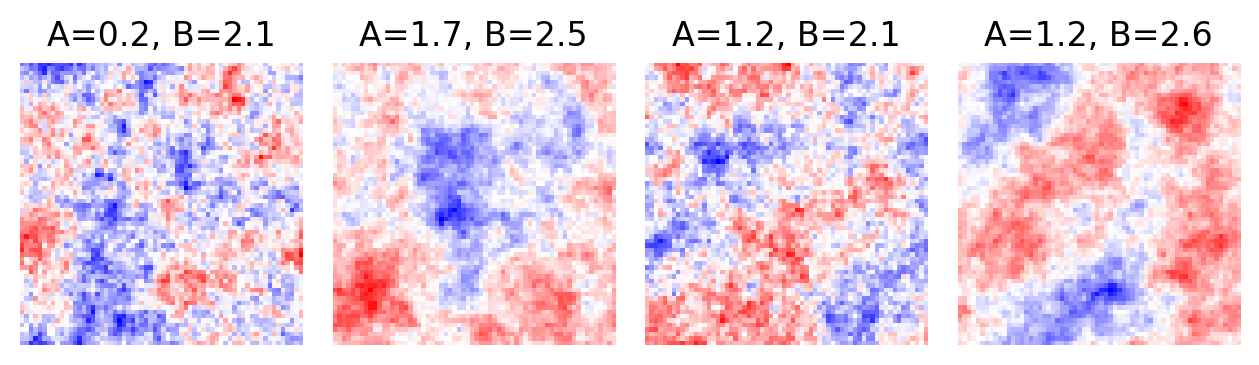

In [6]:
# Model / inference stuff
AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
parameter_names = ["A", "B"]
# Data
n_pix = 64
data_shape = (n_pix, n_pix)
data_dim = np.prod(data_shape)
parameter_dim = len(AB)
# Optimisation
n_steps = 2_000
batch_size = 400

# Load data 
D = np.load(os.path.join(data_dir, f"grfs_{n_pix=}.npy"))
D_ = np.load(os.path.join(data_dir, f"data_{n_pix=}.npy"))
Y = np.load(os.path.join(data_dir, f"grfs_parameters_{n_pix=}.npy"))
Y_original = Y
D_original = D

# Add image channels for convolutions
n_use = 1000
D = D[:n_use, None, ...]
D_ = D_[None, None, ...] # Single batch axis for single measurement
Y = Y[:n_use]

print(f"Simulations: {D.shape=} {Y.shape=}, Data {D_.shape}")

D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.

# Plot some training samples for comparison
fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(D[i].squeeze(), cmap="bwr")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "train_samples.png"))
plt.show()

#### Autoencoder 
Fit autoencoder to create embeddings from high-dimensional dataset

In [ ]:
# Embedding dimension of autoencoder
z_dim = 8
# Hidden dimension (~number of parameters in autoencoder model)
hidden_dim = 1024 

# Build the autoencoder
autoencoder = AutoEncoderC(
    data_dim=data_shape, 
    z_dim=z_dim, 
    hidden_dim=hidden_dim
)
autoencoder = autoencoder.to(device)
autoencoderoder = nn.DataParallel(autoencoder)

# We use a MSE loss for the reconstruction error
loss_f = lambda _x, x: torch.square(torch.subtract(_x, x)).mean() 

optimizer = torch.optim.Adam(
    autoencoder.parameters(), lr=1e-3, weight_decay=1e-5
)
#optimizer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pre, 'min', patience=30, threshold=0.1)

X_train, X_val, Y_train, Y_val = train_test_split(\
                  convert(D), convert(Y).unsqueeze(-1), test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

x_dataloader = get_dataloader_from_arrays(D, Y, batch_size=batch_size)

train_losses, val_losses = [], []
n_steps = 2000
T = trange(n_steps)
for s in T:
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        autoencoder.train()

        # Use autoencoder to return a reconstruction and embedding of input
        _x, emb = autoencoder(x)

        # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
        rec_loss = loss_f(_x, x)

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()

        train_losses.append(rec_loss.item())
        
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        
        autoencoder.eval()
        _x, emb = autoencoder(x)
        rec_loss = loss_f(_x, x)
        
        val_losses.append(rec_loss.item())
        
    T.set_postfix(train_loss=f"{train_losses[-1]:.3E}", val_loss=f"{val_losses[-1]:.3E}")

    if (s+1) % 100 == 0:
        autoencoder.eval()

        x = x.cpu().detach().numpy()
        _x = _x.cpu().detach().numpy()

        # Plot reconstructions against training data
        fig, axs = plt.subplots(2, 4, dpi=200)
        for i, ax in enumerate(axs[0, :]):
            A, B = Y[i]
            ax.set_title(f"{A=:.1f}, {B=:.1f}")
            im = ax.imshow(x[i].reshape(data_shape), cmap="bwr")
            ax.axis("off")
        for i, ax in enumerate(axs[1, :]):
            im = ax.imshow(_x[i].reshape(data_shape), cmap="bwr")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, "autoencoder_reconstructions.png"))
        plt.close()

        # Plot losses as we go
        plt.figure()
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Validation")
        plt.legend()
        plt.yscale('log')
        plt.savefig(os.path.join(figs_dir, "loss_ae.png"))
        plt.close()        

    if (s+1) % 1000 == 0:
        torch.save(autoencoder, os.path.join(data_dir, "ae.pth"))

    if (s+1) == n_steps:
        print("Stopping.")
        break

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
# autoencoder = torch.load(os.path.join(data_dir, "ae.pth"))

# Turn dropout off
autoencoder.eval()

# Encode dataset 
Z = []
for (x, y) in x_dataloader:
    x = x.to(device)
    Z.append(autoencoder.encoder(x))
Z = torch.cat(Z)

#### Normalizing flow
Fit normalizing flow to encoded dataset

In [15]:
# Model
H = 64 # Hidden size
L = 5 # Layers
activation = nn.Tanh 

net_s = lambda: nn.Sequential(
    nn.Linear(z_dim + parameter_dim, H), 
    activation(),
    nn.Linear(H, H), 
    activation(),
    nn.Linear(H, H), 
    activation(),
    nn.Linear(H, z_dim), 
    # activation()
)
net_t = lambda: nn.Sequential(
    nn.Linear(z_dim + parameter_dim, H), 
    activation(), 
    nn.Linear(H, H), 
    activation(), 
    nn.Linear(H, H), 
    activation(), 
    nn.Linear(H, z_dim)
)

# Normalizing flow base distribution
prior = td.MultivariateNormal(
    loc=torch.zeros(z_dim).to(device), 
    covariance_matrix=torch.eye(z_dim).to(device)
)

# Mask arrays for normalizing flow
dim = torch.arange(0, z_dim) % 2
masks = torch.stack(
    [
        dim if i % 2 else dim.flip(dims=(0,))
        for i in range(L)
    ]
)

flow = RealNVP(net_s, net_t, masks, prior) 
flow = flow.to(device)

In [16]:
n_sample = 64

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-5)

z_dataloader = get_dataloader_from_arrays(Z, Y, batch_size=batch_size)

losses = []
with trange(n_steps) as steps:
    for s, (x, y) in zip(steps, looploader(z_dataloader)):

        x, y = x.to(device), y.to(device)

        loss = -flow.log_prob(x, y).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

        if s % 500 == 0:
            # Hold some training data to plot with samples
            x = autoencoder.decoder(x[:4]).cpu().detach().numpy()
            
            # Sample some parameters from the training set
            parameters = Y[np.random.randint(0, len(Y), size=(n_sample,))]
            parameters = convert(parameters).to(device)

            # Sample from the flow conditioned on these parameters
            samples = flow.sample(n_sample, parameters)
            samples = autoencoder.decoder(samples) 
            samples = samples.cpu().detach().numpy()

            # Plot reconstructions against training data
            fig, axs = plt.subplots(2, 4, dpi=200)
            for i, ax in enumerate(axs[0, :]):
                A, B = Y[i]
                ax.set_title(f"{A=:.1f}, {B=:.1f}")
                im = ax.imshow(x[i].reshape(data_shape), cmap="bwr")
                ax.axis("off")
            for i, ax in enumerate(axs[1, :]):
                im = ax.imshow(samples[i].reshape(data_shape), cmap="bwr")
                ax.axis("off")
            plt.tight_layout()
            plt.savefig(os.path.join(figs_dir, "flow_samples.png"))
            plt.close()

            # Plot losses as we go
            plt.figure()
            plt.plot(losses)
            plt.savefig(os.path.join(figs_dir, "loss_nvp_field.png"))
            plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# n_steps batch_size n_use auto_acc flow_acc
# 1000 200 1000 2e-2 -7.5
# 2000 200 1000

i=1000



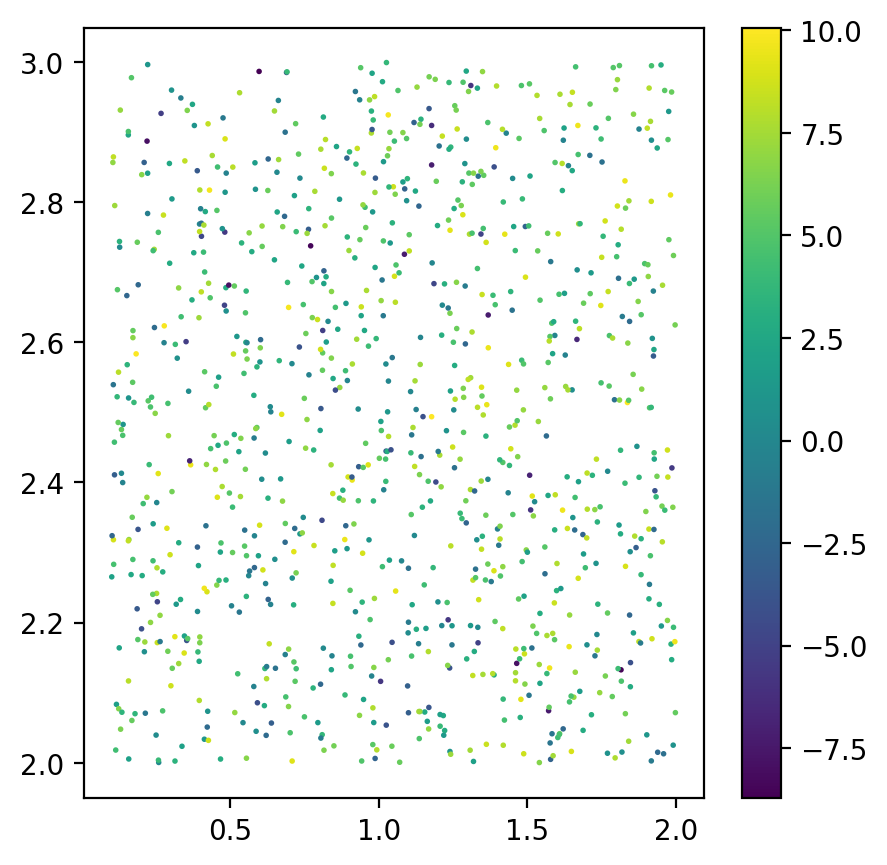

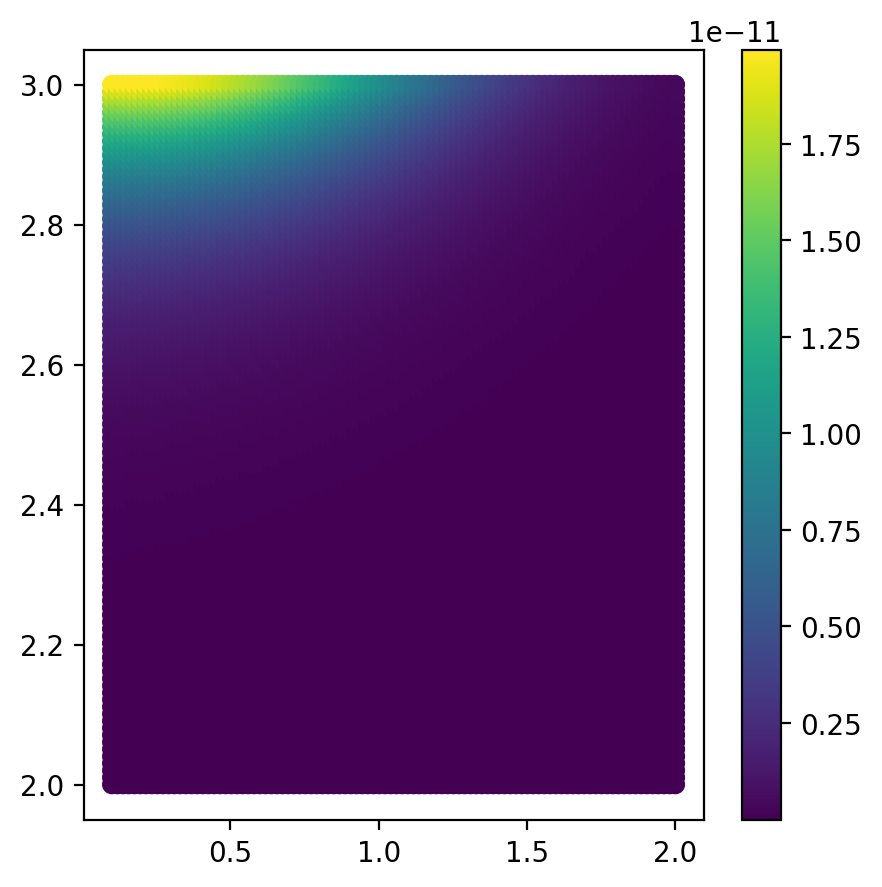

In [18]:
"""
    Map likelihood of flow in parameter space
    - encode data
"""
# Encode dataset 
Lxy = []

x_dataloader = get_dataloader_from_arrays(D, Y, batch_size=1)

#print(D_original.shape)
#print(Y_original.shape)
#Y = Y[:100]

i = 0
for (x, y) in x_dataloader:
    x, y = x.to(device), y.to(device)
    z = autoencoder.encoder(x)
    Lxy.append(flow.log_prob(z, y))
    i+=1
    print(f"\r{i=}", end="")
Lxy = torch.cat(Lxy).cpu().detach().numpy()
print("\n")

plt.figure(dpi=200, figsize=(5., 5.))
plt.scatter(*(Y.T), c=Lxy, s=1.)
plt.colorbar()
plt.savefig(os.path.join(figs_dir, "Lx.png"))
plt.show()
plt.close()

"""
    Plot likelihood in parameter space
"""
# Uniform prior has this value inside the prior
prior_log_prob = np.log(1. / np.prod(upper - lower))

# Grid of parameter points in parameter space
X_, Y_ = np.mgrid[lower[0]:upper[0]:100j, lower[1]:upper[1]:100j]
Y_new = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T.to(device)

# Map data to an encoding
z_ = autoencoder.encoder(torch.Tensor(D_).to(device)).to(device)

# Load pairs of data (repeated) with each parameter point 
Lxy = np.zeros((len(Y_new),))
for i, y in enumerate(Y_new):
    
    y = y.view(1,2).to(device)
    Lxy[i] = np.exp(flow.log_prob(z_, y).cpu().detach().numpy() + prior_log_prob)

plt.figure(dpi=200, figsize=(5., 5.))
plt.scatter(*Y_new.cpu().T, c=Lxy)
plt.colorbar()
plt.savefig(os.path.join(figs_dir, "Lxz.png"))
plt.show()
plt.close()